# Damped Lyman-$\alpha$ Absorption Spectra

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import toolslyman as tl
from astropy import units as u
from tqdm import tqdm

[Toolslyman](https://github.com/sambit-giri/toolslyman) provides a function named `optical_depth_lyA_along_skewer` that models the transmission of lyman-alpha forest spectra through the intergalactic medium. This function assumes the source to be placed at the origin of the neutral fraction array provided. Therefore the skewers (line-of-sight) through the IGM should be adjust according before providing them to the function.

## Toy model

We test our modeling method using some toy models. We assume a large ionized bubble of radius ($R_\mathrm{bubble}$) and a background source producing the spectrum at redshift $z=8.76$. We consider the following cases:
* Model 0: The source is placed at the center of the ionized bubble.
* Model 1: The source is placed far away from the ionized bubble.

In [2]:
z_source = 8.76

dr = 0.5*u.Mpc
r_bins = np.arange(0,300,dr.to('Mpc').value)*u.Mpc 

R_bubble = 25*u.Mpc
xhi_bins0 = np.zeros_like(r_bins.value)
xhi_bins0[r_bins.to('Mpc').value>R_bubble.to('Mpc').value] = 1 
xhi_bins1 = np.flip(xhi_bins0)

dn_bins = np.zeros_like(xhi_bins0)

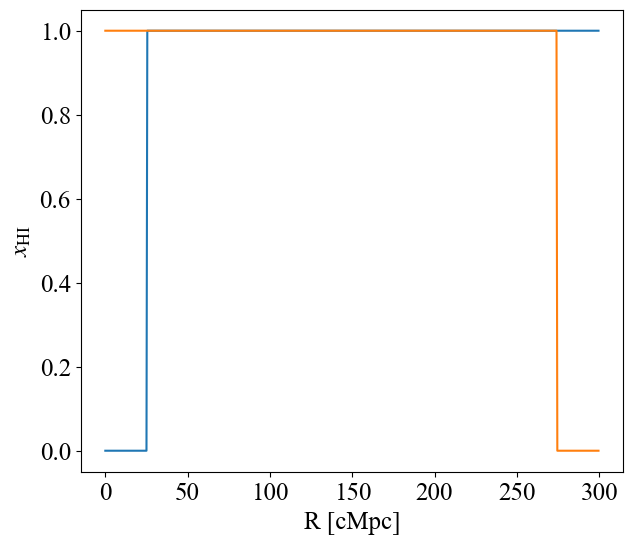

In [3]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.plot(r_bins, xhi_bins0)
ax.plot(r_bins, xhi_bins1)
ax.set_xlabel(r'R [cMpc]')
ax.set_ylabel(r'$x_\mathrm{HI}$')
plt.show()

The skewers (xhi_bins0 and xhi_bins1) could be provided one by one of put together by stacking into one array and then give to the `optical_depth_lyA_along_skewer` function. The over-density (dn_bins) and temperature (temp) array can have the same shape as the neutral fraction array. If not, the same over-density and temperature array will be used for all the skewers.

In [4]:
xhi_bins = np.vstack((xhi_bins0,xhi_bins1)); 
print(xhi_bins.shape)

tau_lambda, lambda_obs = tl.optical_depth_lyA_along_skewer(z_source, xhi_bins, dn_bins, dr, 
                                                        temp=1e4*u.K, cosmo=None,
                                                        damped=True, verbose=True)
print(tau_lambda.shape, lambda_obs.shape)

(2, 600)
Skewer Number 1/2
 including a damping wing
Skewer Number 2/2
 including a damping wing
(2, 1200) (1200,)


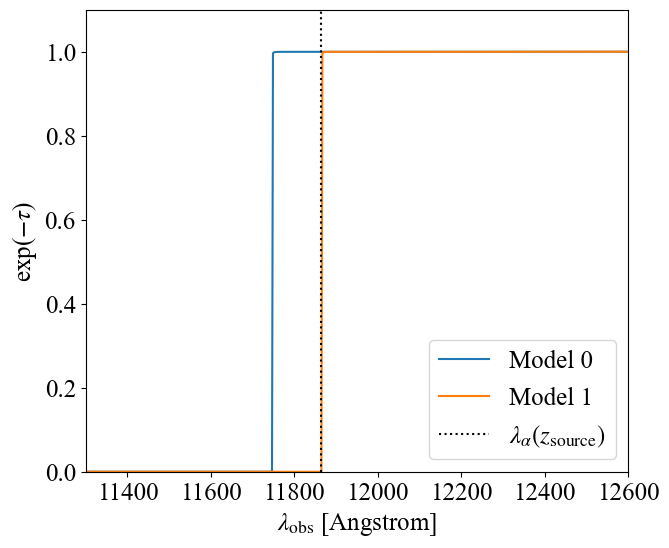

In [5]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.plot(lambda_obs.to('AA').value, np.exp(-tau_lambda[0]), c='C0', label='Model 0')
ax.plot(lambda_obs.to('AA').value, np.exp(-tau_lambda[1]), c='C1', label='Model 1')
ax.axvline((1215.67*u.AA*(1+z_source)).value, color='k', ls=':', label=r'$\lambda_\alpha(z_\mathrm{source})$')
ax.set_xlabel(r'$\lambda_\mathrm{obs}$ [Angstrom]')
ax.set_ylabel(r'exp($-\tau$)')
ax.legend()
ax.set_ylim(0,1.1)
ax.set_xlim(11300,12600)
plt.show()